In [22]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import math

In [3]:
def objfun(x,y):
    
    """ 
    This function calculates the objective function value corresponding to x and y

    Parameters: 
        x (float): x-value of candidate solution
        y (float): y-value of candidate solution

    Returns: 
        f (float): objective function value for f1 and f2: [f1,f2]
    """
    
    f = -(y + 47) * np.sin(np.sqrt(np.abs(y + x/2 + 47))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    
    return f

In [77]:
def check_feasibility(z):
    
    """ 
    This function checks whether the candidate solution is feasible according to given constraint

    Parameters: 
        z (float): x-value or y-value of candidate solution

    Returns: 
        feasibility_flag (bool): The flag that indicates whether the candidate solution is feasible. 
                                 If it is, then feasibility_flag = True, else False
    """
    
    # Set constraint values
    constr_ceiling = 512
    const_floor = -512
    
    # Check whether the candidate solution is valid subject to problem constraint, return True is yes and False if no
    if z <= constr_ceiling and z >= const_floor:
        
        feasibility_flag = True
        
    else:
        
        feasibility_flag = False
    
    return feasibility_flag   

In [78]:
def mutate_coord(x_y, scale):
    
    """ 
    This function mutates x- or y-coordinates by sampling a normal distribution around the point in question
    with sigma = scale

    Parameters: 
        scale (float): scale (sigma) of normal distribution for use in the mutation of coordinates
        n (int): number of particles
        
    Returns: 
        x_y_new (float): Mutated coordinate
    """
    
    # Generate new value for coordinate in question by sampling a normal distribution
    x_y_new = np.random.normal(x_y, scale = scale)
    
    return x_y_new     

In [79]:
def generate_neighbourhood(data_store, n, m, scale):
    
    """ 
    This function generates a neighbourhood of m neighbours for n particles

    Parameters: 
        data_store (DataFrame): Dataframe containing all x, y, f and x_best, y_best, f_best values
        n (int): number of particles
        m (int): number of neighbours to be generated
        scale (float): scale (sigma) of normal distribution for use in the mutation of coordinates
        
    Returns: 
        neighbour_store (dataframe): DataFrame that stores all neighbours of x, y for all particles
    """    
    
    # Initialise neigh_store DataFrame
    neigh_store = pd.DataFrame()
    
    # Iterate over all particles
    for i in range(n):
        
        # Extract particle i's coordinates
        x = data_store.loc[len(data_store)-1, "x_" + str(i)]
        y = data_store.loc[len(data_store)-1, "y_" + str(i)]
        
        # Generate and store m neighbours
        for j in range(m):
            
            # Generate new solution
            x_new = mutate_coord(x, scale)
            y_new = mutate_coord(y, scale)
            
            # If new solutions are not feasible, keep trying until a feasible solution is created
            while (check_feasibility(x_new) & check_feasibility(y_new)) == False:
                
                x_new = mutate_coord(x, scale)
                y_new = mutate_coord(y, scale)
            
            # Store new solution
            f_new = objfun(x_new,y_new)
                                
            # Store neighbours in neigh_store DataFrame
            neigh_store.loc[j, "x_"+str(i)] = x_new
            neigh_store.loc[j, "y_"+str(i)] = y_new
            neigh_store.loc[j, "f_"+str(i)] = f_new
            
    return neigh_store

In [80]:
def dataframe_init(particles):
    
    """ 
    This function initialises a dataframe according to the number of particles passed based
    It stores the particle positions and objective function values.
    It also creates columns to store incumbent solutions for each particle

    Parameters: 
        particles (dataframe): A DataFrame containing all particle positions

    Returns: 
        data_store (DataFrame): Dataframe outlined in the function description
    """
    
    # Initialise list to store column names
    columns_list = []
    
    # Iterate over all particles to create columns
    for i in range(len(particles)):

        columns_list.append("x_"+str(i))
        columns_list.append("y_"+str(i))
        columns_list.append("f_"+str(i))

    # Initialise dataframe with all column names
    data_store = pd.DataFrame(columns = columns_list)
    
    # Iterate over all particles to store initial values (best = initial)
    for j in range(len(particles)):

        data_store.loc[0,"x_"+str(j)] = particles.loc[j,'x_init']
        data_store.loc[0,"y_"+str(j)] = particles.loc[j,'y_init']
        data_store.loc[0,"f_"+str(j)] = particles.loc[j,'f_init']
        
    return data_store

In [81]:
def check_best(data_store, neigh_store, n):

    """ 
    This function checks the neighbours of each particle for improved solutions, 
    If found, the better solution becomes the incumbent solution

    Parameters: 
        data_store (DataFrame): Dataframe containing all x, y, f and x_best, y_best, f_best values
        neigh_store (dataframe): DataFrame that stores all neighbours of x, y for all particles
        global_best (list): list containing current global best solution 
        n (int): number of particles

        
    Returns: 
        data_store (DataFrame): Dataframe containing all x, y, f and x_best, y_best, f_best values
    """    
    
    # Index of current soltutions
    current_idx = len(data_store) - 1
    
    for i in range(n):
        
        # Obtain best solution in generated neighbours
        f_best_neigh = neigh_store['f_' + str(i)].min()

        # Check whether best neighbour is better than previous best and assign as best if yes.
        if f_best_neigh < data_store.loc[current_idx,'f_' + str(i)]:
            
            # Obtain index of best neighbouring solution
            f_best_neigh_idx = neigh_store['f_' + str(i)].idxmin()
            
            # Store best neighbouring solution in data_store
            data_store.loc[current_idx+1, 'x_' + str(i)] = neigh_store.loc[f_best_neigh_idx, 'x_' + str(i)]
            data_store.loc[current_idx+1, 'y_' + str(i)] = neigh_store.loc[f_best_neigh_idx, 'y_' + str(i)]
            data_store.loc[current_idx+1, 'f_' + str(i)] = neigh_store.loc[f_best_neigh_idx, 'f_' + str(i)]

        else: 
            
            # Store current incumbent as best solution
            data_store.loc[current_idx+1, 'x_' + str(i)] = data_store.loc[current_idx, 'x_' + str(i)]
            data_store.loc[current_idx+1, 'y_' + str(i)] = data_store.loc[current_idx, 'y_' + str(i)]
            data_store.loc[current_idx+1, 'f_' + str(i)] = data_store.loc[current_idx, 'f_' + str(i)]

    return data_store

In [82]:
def compare_plot_df(data_store,n):
    
    """ 
    This function transforms the data_store dataframe to a datframe containing only
    the initial and latest solutions in columns ['x', 'y', 'f', 'x_init', 'y_init', 'f_init'].
    
    This DataFrame is used for comparisons of the final solutions and plotting

    Parameters: 
        data_store (DataFrame): Dataframe containing all x, y, f and x_best, y_best, f_best values
        n (int): number of particles
        
    Returns: 
        compare_plot (DataFrame): Dataframe as described out above
    """    

    compare_plot = pd.DataFrame()

    for i in range(n):

        compare_plot.loc[i,'x'] = data_store.loc[len(data_store)-1, ['x_'+str(i)]][0]
        compare_plot.loc[i,'y'] = data_store.loc[len(data_store)-1, ['y_'+str(i)]][0]
        compare_plot.loc[i,'f'] = data_store.loc[len(data_store)-1, ['f_'+str(i)]][0]
        compare_plot.loc[i,'x_init'] = data_store.loc[0, ['x_'+str(i)]][0]
        compare_plot.loc[i,'y_init'] = data_store.loc[0, ['y_'+str(i)]][0]
        compare_plot.loc[i,'f_init'] = data_store.loc[0, ['f_'+str(i)]][0]

    return compare_plot

In [83]:
def search_best(compare_plot):
    
    """ 
    This function compares the current position of all particles and returns the global best

    Parameters: 
        compare_plot (DataFrame): DataFrame containing the initial and latest solutions
        
    Returns: 
        global_best (list): list of globally best solution of the 5 particles in [x_best, y_best, f_best]
    """  
    # Declare global_best list
    global_best = []
    
    # Extract and store the global best solution
    search_best_x = compare_plot.loc[compare_plot['f'].idxmin(), 'x']
    search_best_y = compare_plot.loc[compare_plot['f'].idxmin(), 'y']
    search_best_f = compare_plot.loc[compare_plot['f'].idxmin(), 'f']
    search_best_df = [search_best_x, search_best_y, search_best_f]
    
    return search_best_df

In [84]:
def stopping_criteria(data_store, n):
    
    """ 
    This function calculates delta_f_sum which is the sum over all particles the of distance 
    between a particle's latest solution and it's previous solution
    This is used as part of the stopping criteria rules

    Parameters: 
        data_store (DataFrame): Dataframe containing all x, y, f and x_best, y_best, f_best values
        n (int): number of particles
        
    Returns: 
        delta_f_sum (float): the sum over all particles the of distance between a particle's latest solution 
                             and its previous solution
    """  
    
    delta_f_sum = 0
    
    for i in range(n):
        
        delta_f = data_store.loc[len(data_store)-1, 'f_' + str(i)] - data_store.loc[len(data_store)-2, 'f_' + str(i)]
        delta_f_sum = delta_f_sum + delta_f
        
    return delta_f_sum

In [286]:
# Import particles as discussed in report
particles = pd.read_csv('q2_particles.csv')

# Calculate number of particles
n = len(particles)

# Declare number of neighbours generated in each iteration
m = 5

# Declare scale_factor for geometric decay of scale 
scale_factor = 1

# Number of iterations with negligible improvement
stop_cond_max = 10

# Initialise data_store with initial particle positions
data_store = dataframe_init(particles)

# DataFrame to record incumbent solutions after each search
incumbent_sols = pd.DataFrame(columns = data_store.columns)

# Initialise delta_sum as infinite
delta_f_sum = np.inf

# Iteration counter
t = 0

# Reset initial scale for mutation and stopping condition counter
scale = 0.05
stop_cond_count = 0

# Initialise data_store with initial particle positions
data_store = dataframe_init(particles)

# Declare stop_flag
stop_flag = False

while stop_flag == False:

    # Generate neighbours
    neigh_store = generate_neighbourhood(data_store, n, m, scale)

    # Check for best solution
    data_store =  check_best(data_store, neigh_store, n)

    # After second iteration start checking the stopping condition
    if t > 0:

        delta_f_sum = stopping_criteria(data_store, n)

    # If sum of all changes in particle positions is less than 0.0001, increment stop_cond_count
    if np.abs(delta_f_sum) == 0:

        stop_cond_count = stop_cond_count + 1

    # If not, reset stop_cond_count
    else: 

        stop_cond_count = 0

    # Calculate new scale according to geometric decay factor
    scale = scale * scale_factor

    # Increment iteration counter
    t = t + 1

    # Check for stopping condition
    if stop_cond_count == stop_cond_max:

        stop_flag = True

# Generate DataFrame for particle comparisons and plotting functions        
compare_plot = compare_plot_df(data_store,n)

,x,y,f,x_init,y_init,f_init
0,511.999172,404.139938,-959.628424,492.350904,437.875282,-653.111298
1,511.986618,404.291427,-959.589497,502.378952,440.404416,-99.458667


In [277]:
objfun(502.378952,440.404416)

-99.45866744410938

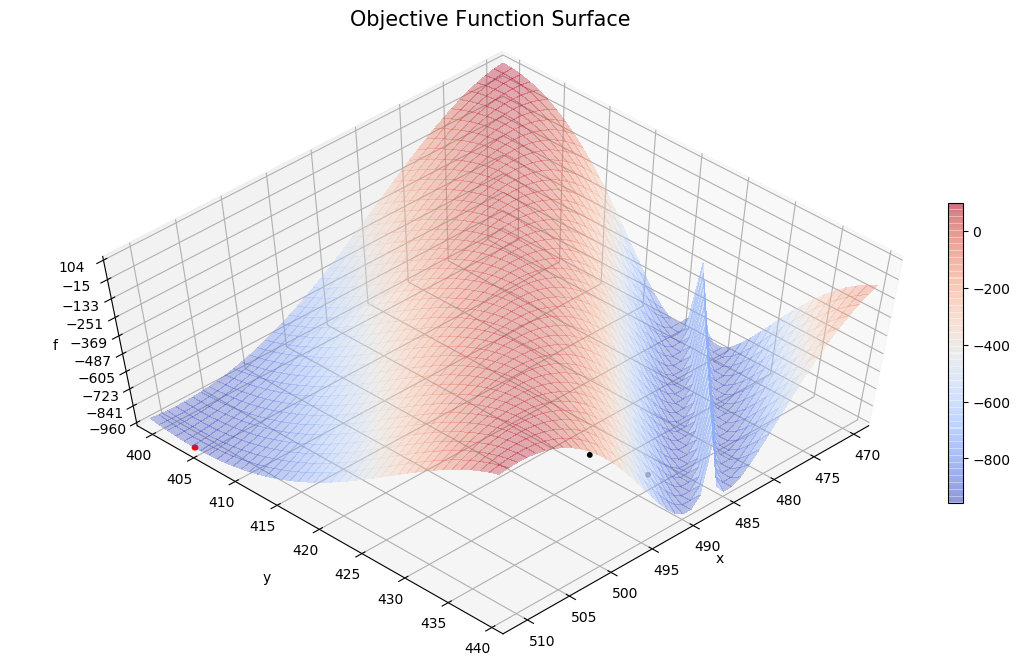

In [287]:
x1 = np.array(compare_plot['x'], dtype=float)
y1 = np.array(compare_plot['y'], dtype=float)
f1 = np.array(compare_plot['f'], dtype=float)
x1_init = np.array(compare_plot['x_init'], dtype=float)
y1_init = np.array(compare_plot['y_init'], dtype=float)
f1_init = np.array(compare_plot['f_init'], dtype=float)

# %matplotlib widget
plt.style.use('default')
x = np.arange(469, 513, 1)
y = np.arange(399, 441, 1)
x, y = np.meshgrid(x, y)
f = objfun(x,y)
# figsize=(14,8)
fig = plt.figure(figsize=(12,6))
ax = Axes3D(fig)

surf = ax.plot_surface(x, y, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.35)

# ax.scatter(x1, y1, f1, s=10, depthshade=True, c='r')
ax.scatter(x1_init, y1_init, f1_init, s=10, depthshade=True, c='k')
ax.scatter(x1, y1, f1, s=10, depthshade=False, c='r')

ax.view_init(60, 45)
plt.draw()
# plt.pause(.001)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.set(xlabel='x', ylabel='y', zlabel = 'f')
ax.yaxis.labelpad = 20
# ax.set_zticklabels([])

ax.margins(0)
fig.colorbar(surf, shrink=0.5, aspect=20,anchor=(-0.5,0.5))
plt.title('Objective Function Surface',pad=20, fontdict = {'fontsize': 15, 'fontweight' : 3})
plt.show()
fig.savefig('Q2 surface plot 60-45 final.png',dpi=300,bbox_inches = 'tight')

In [ ]:
# Declare global_best list
global_best = []

global_best_x = compare_plot.loc[compare_plot['f'].idxmin(), 'x']
global_best_y = compare_plot.loc[compare_plot['f'].idxmin(), 'y']
global_best_f = compare_plot.loc[compare_plot['f'].idxmin(), 'f']
global_best = [global_best_x, global_best_y, global_best_f]

In [ ]:
global_best

In [ ]:
a = pd.DataFrame(col)

In [ ]:
compare_plot_all = compare_plot
for i in range(n):
    
    min_f_idx = incumbent_sols['f_' + str(i)].idxmin()
    
    compare_plot_all['x'] = incumbent_sols.loc[min_f_idx, 'x_' + str(i)]
    compare_plot_all['y'] = incumbent_sols.loc[min_f_idx, 'y_' + str(i)]
    compare_plot_all['f'] = incumbent_sols.loc[min_f_idx, 'f_' + str(i)]

In [ ]:
a.loc[0,'test2'] = 1

In [ ]:
a

In [ ]:
data_store

In [ ]:
data_store = pd.read_csv('2020811 2144.csv', index_col=False).drop('Unnamed: 0', axis=1)

In [ ]:
local_particles = plot_df[(plot_df['x_init'] >= 200) & (plot_df['y_init'] >= 200)][['x_init','y_init','f_init']]

In [ ]:
local_particles.to_csv('q2_particles.csv', index=False)